# Analyze & create excel files of gage points vs closest AAs

reads from 
- unids.txt (list of cultivated ids with unique attributes)
- db.json
- plot_util.py (for making pie graphs)

writes to gp_aas_total.xlsx and gp_aas_unique.xlsx with the data from all ids and the unique ids, respectively;  
\<genome\>_aas_total.xlsx & \<genome\>_aas_unique.xlsx with filtered data for each genome type

In [7]:
import pandas as pd
import json
from plot_util import *

with open('unids.txt', 'r') as f:
    unids = [i.replace('\n', '') for i in f]
with open('db.json', 'r') as f:
    data = json.load(f)

ids = list(data['data'].keys())

In [8]:
#STRUCTURAL AAS (from Viper)

aa_freq_total = {}
for i in ids:
    if i in data['aas']:
        for k in data['aas'][i]:
            if k in aa_freq_total: aa_freq_total[k] += data['aas'][i][k]
            else: aa_freq_total[k] = data['aas'][i][k]


aa_freq_un = {}
for i in unids:
    if i in data['aas']:
        for k in data['aas'][i]:
            if k in aa_freq_un: aa_freq_un[k] += data['aas'][i][k]
            else: aa_freq_un[k] = data['aas'][i][k]


gp_aa_freq_un = {}
for i in unids:
    if i in data['data'] and 'closest_gp_aa' in data['data'][i].keys():
        caa = data['data'][i]['closest_gp_aa']
        if caa not in gp_aa_freq_un: gp_aa_freq_un[caa] = 0
        gp_aa_freq_un[caa] += 1

#piegraph(aa_freq_total, 'aa frequency over all viruses')

#piegraph(aa_freq_un, 'aa frequency over unique viruses')

In [9]:
id_gp = {v: data['data'][v]['gauge_point'] for v in ids if 'gauge_point' in data['data'][v].keys()}
gplist = list(set(id_gp.values()))
gplist = [str(i) for i in sorted([int(g) for g in gplist])]

aalist = ['HIS','ILE', 'ASP', 'ALA', 'PHE', 'ASN', 'GLY', 'SER', 'GLU', 'TRP', 'MET', 'THR', 'CYS', 'ARG', 'PRO', 'LYS', 'UNK', 'VAL', 'GLN', 'TYR', 'LEU']

In [10]:
gp_aa_dict = {}
for g in gplist:
    gp_aa_dict[g] = {a:0 for a in aalist}
    for i in ids:
        if i in id_gp and id_gp[i] == g and 'closest_gp_aa' in data['data'][i].keys():
            caa = data['data'][i]['closest_gp_aa']
            if caa not in gp_aa_dict[g]: gp_aa_dict[g][caa] = 0
            gp_aa_dict[g][caa] += 1

In [11]:
gp_aa_dict_un = {}
for g in gplist:
    gp_aa_dict_un[g] = {a:0 for a in aalist}
    for i in unids:
        if i in id_gp and id_gp[i] == g and 'closest_gp_aa' in data['data'][i].keys():
            caa = data['data'][i]['closest_gp_aa']
            if caa not in gp_aa_dict_un[g]: gp_aa_dict_un[g][caa] = 0
            gp_aa_dict_un[g][caa] += 1

In [12]:
id_genome = {k:v['genome'] if v['genome'] != '' else 'NA' for k,v in data['data'].items() if 'genome' in v}
genome_gp_aa_dict = {}
for g in list(set(id_genome.values())):
    genome_gp_aa_dict[g] = {}
    id_pool = [i for i in unids if i in id_genome and id_genome[i] == g]
    for gp in gplist:
        genome_gp_aa_dict[g][gp] = {a:0 for a in aalist}
        for i in id_pool:
            if i in id_gp and id_gp[i] == gp and 'closest_gp_aa' in data['data'][i]:
                caa = data['data'][i]['closest_gp_aa']
                if caa not in genome_gp_aa_dict[g][gp]: genome_gp_aa_dict[g][gp][caa] = 0
                genome_gp_aa_dict[g][gp][caa] += 1

In [13]:
#create excel file with the count of viruses with a given pair of AAs closest to GP and GP#
#then filter this file by genome into files for each genome category

df = pd.DataFrame.from_dict(gp_aa_dict_un)
df.to_excel('gp_aas_unique.xlsx')
total_df = pd.DataFrame.from_dict(gp_aa_dict)
total_df.to_excel('gp_aas_total.xlsx')

for k,v in genome_gp_aa_dict.items():
    df = pd.DataFrame.from_dict(v)
    df.to_excel(f"{k}_aas_unique.xlsx")


In [14]:
#check for capsids with aa values not in AA list
unk_aas = []
gp_aa_freq_total = {}
for i in ids:
    if i in data['data'] and 'closest_gp_aa' in data['data'][i].keys():
        caa = data['data'][i]['closest_gp_aa']
        if caa == 'UNK': unk_aas.append(i)
        if caa not in gp_aa_freq_total: gp_aa_freq_total[caa] = 0
        gp_aa_freq_total[caa] += 1
unk_aas

['7od8', '4c10', '1tnv', '4c0y', '7oev', '6q0b', '4c0u', '7oen']

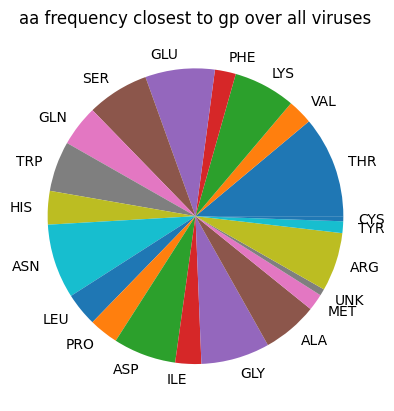

In [15]:
piegraph(gp_aa_freq_total, 'aa frequency closest to gp over all viruses')

In [16]:
gp_aa_freq_un = {}
for i in unids:
    if i in data['data'] and 'closest_gp_aa' in data['data'][i].keys():
        caa = data['data'][i]['closest_gp_aa']
        if caa not in gp_aa_freq_un: gp_aa_freq_un[caa] = 0
        gp_aa_freq_un[caa] += 1

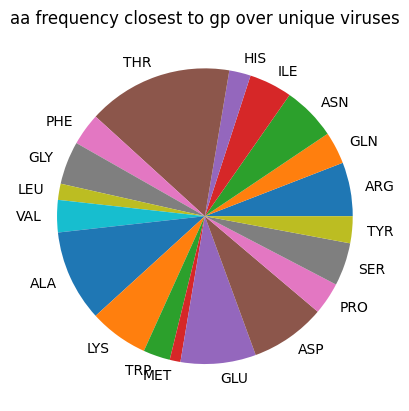

In [17]:
piegraph(gp_aa_freq_un, 'aa frequency closest to gp over unique viruses')

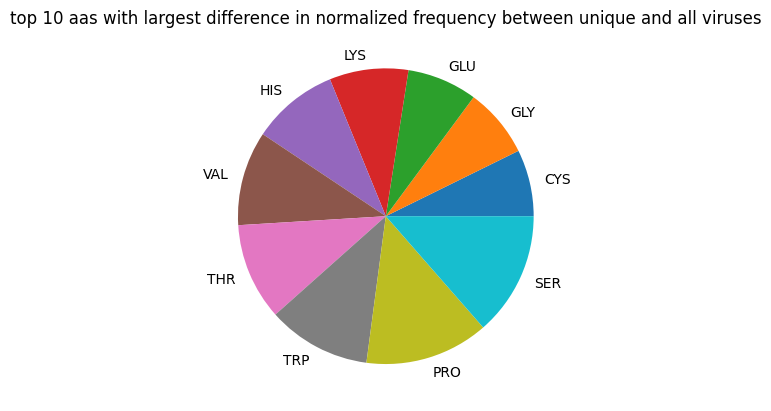

In [18]:
#divide by max to normalize
tm = max(aa_freq_total.values())
aa_freq_total_norm = {k:v/tm for k,v in aa_freq_total.items()}

um = max(aa_freq_un.values())
aa_freq_un_norm = {k:v/um for k,v in aa_freq_un.items()}

diff = {k: aa_freq_total_norm[k] - (aa_freq_un_norm[k] if k in aa_freq_un_norm else 0) for k in aa_freq_total_norm}

#diff sorted by magnitude; positive means all_ids had more & negative means unids had more
#dict(sorted(diff.items(), key=lambda item: abs(item[1])))


diff_abs = {k: abs(aa_freq_total_norm[k] - (aa_freq_un_norm[k] if k in aa_freq_un_norm else 0)) for k in aa_freq_total_norm}

n = 10 # number of aas to show
diff_abs_topn = dict(sorted(diff_abs.items(), key=lambda item: item[1])[-n:])
piegraph(diff_abs_topn, f'top {n} aas with largest difference in normalized frequency between unique and all viruses')

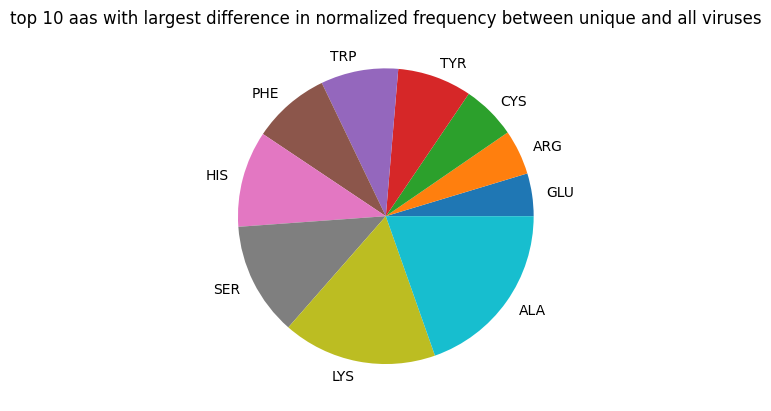

In [20]:
#plot frequency differences, this time among ALL aas within 5 Angstroms of any point array points

aa_freq_total = {}
for i in ids:
    if i in data['close_aas']:
        for k in data['close_aas'][i]:
            if k in aa_freq_total: aa_freq_total[k] += data['close_aas'][i][k]
            else: aa_freq_total[k] = data['close_aas'][i][k]


aa_freq_un = {}
for i in unids:
    if i in data['close_aas']:
        for k in data['close_aas'][i]:
            if k in aa_freq_un: aa_freq_un[k] += data['close_aas'][i][k]
            else: aa_freq_un[k] = data['close_aas'][i][k]


tm = max(aa_freq_total.values())
aa_freq_total_norm = {k:v/tm for k,v in aa_freq_total.items()}

um = max(aa_freq_un.values())
aa_freq_un_norm = {k:v/um for k,v in aa_freq_un.items()}

diff = {k: aa_freq_total_norm[k] - (aa_freq_un_norm[k] if k in aa_freq_un_norm else 0) for k in aa_freq_total_norm}

#diff sorted by magnitude; positive means all_ids had more & negative means unids had more
#dict(sorted(diff.items(), key=lambda item: abs(item[1])))

#piegraph(aa_freq_total, 'aa frequency over all viruses')

#piegraph(aa_freq_un, 'aa frequency over unique viruses')

diff_abs = {k: abs(aa_freq_total_norm[k] - (aa_freq_un_norm[k] if k in aa_freq_un_norm else 0)) for k in aa_freq_total_norm}

n = 10 # number of aas to show
diff_abs_topn = dict(sorted(diff_abs.items(), key=lambda item: item[1])[-n:])
piegraph(diff_abs_topn, f'top {n} aas with largest difference in normalized frequency between unique and all viruses')